<a href="https://colab.research.google.com/github/FadlyHaikal/DigitRecognition/blob/main/digitrecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install streamlit==1.13.0
!npm install -g localtunnel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 0.929s


In [3]:
!pip install streamlit-drawable-canvas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm, preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocess

In [6]:
def drawSquare(image):
	'''
	Draws a square around the found digits
	'''		
	b = [0,0,0]
	height, width = image.shape[0], image.shape[1]
	if(height == width): ## if square
		square = image
		return square
	else:
		d_size = cv2.resize(image, (2*width, 2*height), interpolation=cv2.INTER_CUBIC)
		height, width = height * 2, width * 2
		if (height > width):
			padding = int((height - width)/2)
			d_size_square = cv2.copyMakeBorder(d_size, 0, 0, padding, padding, cv2.BORDER_CONSTANT, None,value=b)
		else:
			padding = int((width - height)/2)
			d_size_square = cv2.copyMakeBorder(d_size, padding, padding, 0, 0, cv2.BORDER_CONSTANT, None,value=b)

	return d_size_square

In [7]:
def resize(image, dim):
	'''
	Returns orignal image resized to shape 'dim'
	'''	
	b = [0,0,0]	 			
	dim = dim - 4
	squared = image
	r = (float(dim) / squared.shape[1])
	d = (dim, int(squared.shape[0] * r))
	resized = cv2.resize(image, d, interpolation = cv2.INTER_AREA)
	height, width = resized.shape[0], resized.shape[1];
	if (height > width):
		resized = cv2.copyMakeBorder(resized, 0,0,0,1, cv2.BORDER_CONSTANT, value=b)
	if (height < width):
		resized = cv2.copyMakeBorder(resized, 1,0,0,0, cv2.BORDER_CONSTANT, value=b)

	resized = cv2.copyMakeBorder(resized, 2,2,2,2,cv2.BORDER_CONSTANT, value=b)
	height, width = resized.shape[0], resized.shape[1]	
	
	return resized	

KNN

In [8]:
def get_path_list(root_path):
    # compute list directories in root path
    root = os.listdir(root_path) 
    # initilize array to store folder path in root directory 
    folder_path_list = [] 

    # looping through root directory
    for index, folder_path in enumerate(root):
        # append folder path
        folder_path_list.append(folder_path)

    return folder_path_list

In [9]:
def get_class_id(root_path, train_names):
    # initilize array to store image and class id
    image_list = []
    image_blur_list = []
    image_class_list = []

    # looping through list of folder or train names path
    for image_class, folder_path in enumerate(train_names):
        full_folder_path = f'{root_path}/{folder_path}'
        # compute list image path
        folder = os.listdir(full_folder_path)
        # looping through list of image in folder
        for index, image_path in enumerate(folder):
            full_image_path =  f'{full_folder_path}/{image_path}'
            # load the image
            image = cv2.imread(full_image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.GaussianBlur(image, (5,5), 0)
            image_blur_list.append(image)
            
            # append image list with the image
            image_list.append(cv2.resize(image, (100,100)).flatten())
            # append image class list with class of the image
            image_class_list.append(image_class)
    
    image_list = np.array(image_list).astype(np.float32)
    image_class_list = np.array(image_class_list).astype(np.float32)
    
    return image_list, image_class_list, image_blur_list

In [10]:
# Loading the digits data
data = cv2.imread('./drive/MyDrive/DigitRecognition_Dataset/digits.png')
gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)

# Resizing each digit from 20x20 to 10x10
resized = cv2.pyrDown(gray)

# Splitting image original image into 5000 different arrays of size 20x20
# Resulting array: 50 * 100 * 20 * 20
arr = [np.hsplit(i, 100) for i in np.vsplit(gray, 50)]
arr = np.array(arr)

# Spliting into training and test set
# Total: 5000, Train: 3500 images, Test: 1500
X_train_mnist = arr[:, :70].reshape(-1, 400).astype(np.float32)
X_test_mnist = arr[:, 70:100].reshape(-1, 400).astype(np.float32)

## Targets for each image
y = [0,1,2,3,4,5,6,7,8,9]

y_train_mnist = np.repeat(y, 350)[:, np.newaxis]
y_test_mnist = np.repeat(y, 150)[:, np.newaxis] 

In [11]:
train_root_path = './drive/MyDrive/DigitRecognition_Dataset/Train'
train_names = get_path_list(train_root_path)
train_image_list, image_classes_list, image_blur_list = get_class_id(train_root_path, train_names)

(X_train, X_test, y_train, y_test) = train_test_split(train_image_list, image_classes_list, test_size=0.25, random_state=42)

---OpenCV KNN---

In [12]:
# Using K-NN(k- nearest neighbors) as the ML algorithm
classifier_knn = cv2.ml.KNearest_create()
classifier_knn.train(X_train_mnist, cv2.ml.ROW_SAMPLE, y_train_mnist)
response, result, neighbours, distance = classifier_knn.findNearest(X_test_mnist, k=3)

# Testing and calculating the accuracy of knn classifier
correct = result == y_test_mnist
correct = np.count_nonzero(correct)
accuracy = correct * (100.0/result.size)
print ("MNIST Dataset : ", accuracy)

MNIST Dataset :  93.46666666666667


In [13]:
# Using K-NN(k- nearest neighbors) as the ML algorithm
model_cv_knn = cv2.ml.KNearest_create()
model_cv_knn.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
response, result, neighbours, distance = model_cv_knn.findNearest(X_test, k=3)

# Testing and calculating the accuracy of knn classifier
res_flatten = result.flatten()
correct = res_flatten == y_test
correct = np.count_nonzero(correct)
accuracy = correct * (100/res_flatten.size)
print ("Manual Dataset : ", accuracy)

Manual Dataset :  69.81132075471699


---KNN SKLEARN---

In [14]:
model_knn_sklearn = KNeighborsClassifier(n_neighbors=5,algorithm='auto',n_jobs=10)
model_knn_sklearn.fit(X_train_mnist,y_train_mnist)
confidence = model_knn_sklearn.score(X_test_mnist,y_test_mnist)
y_pred_mnist = model_knn_sklearn.predict(X_test_mnist)
accuracy = accuracy_score(y_test_mnist, y_pred_mnist)
print ("MNIST Dataset : ", accuracy*100)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


MNIST Dataset :  93.13333333333334


In [15]:
model_knn_sklearn = KNeighborsClassifier(n_neighbors=5,algorithm='auto',n_jobs=10)
model_knn_sklearn.fit(X_train,y_train)
confidence = model_knn_sklearn.score(X_test,y_test)
y_pred = model_knn_sklearn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print ("Manual Dataset : ", accuracy*100)

Manual Dataset :  66.0377358490566


---Random Forest---

In [16]:
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=10)
model_rf.fit(X_train_mnist,y_train_mnist)
confidence = model_rf.score(X_test_mnist,y_test_mnist)
y_pred_mnist = model_rf.predict(X_test_mnist)
accuracy = accuracy_score(y_test_mnist, y_pred_mnist)
print ("MNIST Dataset : ", accuracy*100)

<ipython-input-16-d210f56e470b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_mnist,y_train_mnist)


MNIST Dataset :  93.60000000000001


In [17]:
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=10)
model_rf.fit(X_train,y_train)
confidence = model_rf.score(X_test,y_test)
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print ("Manual Dataset : ", accuracy*100)

Manual Dataset :  71.69811320754717


---Tensorflow Keras---

In [18]:
# Sequential create a stack of layers
model_tensor = keras.Sequential([
    keras.layers.Dense(10, input_shape=(400,), activation='sigmoid')
])

# Optimizer will help in backproagation to reach better global optima
model_tensor.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Does the training
model_tensor.fit(X_train_mnist, y_train_mnist, epochs=50)
model_tensor.evaluate(X_test_mnist, y_test_mnist)

Epoch 1/50
110/110 [==============================] - 1s 1ms/step - loss: 48.9999 - accuracy: 0.4369
Epoch 2/50
110/110 [==============================] - 0s 1ms/step - loss: 11.3833 - accuracy: 0.7526
Epoch 3/50
110/110 [==============================] - 0s 1ms/step - loss: 7.4704 - accuracy: 0.8203
Epoch 4/50
110/110 [==============================] - 0s 1ms/step - loss: 5.9438 - accuracy: 0.8429
Epoch 5/50
110/110 [==============================] - 0s 1ms/step - loss: 4.8182 - accuracy: 0.8569
Epoch 6/50
110/110 [==============================] - 0s 1ms/step - loss: 3.9350 - accuracy: 0.8809
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 3.4129 - accuracy: 0.8917
Epoch 8/50
110/110 [==============================] - 0s 1ms/step - loss: 2.9698 - accuracy: 0.8966
Epoch 9/50
110/110 [==============================] - 0s 2ms/step - loss: 2.6471 - accuracy: 0.9051
Epoch 10/50
110/110 [==============================] - 0s 1ms/step - loss: 2.4723 - accuracy: 0.91

[7.593641757965088, 0.8600000143051147]

In [20]:
# Sequential create a stack of layers
model_tensor = keras.Sequential([
    keras.layers.Dense(10, input_shape=(10000,), activation='sigmoid')
])

# Optimizer will help in backproagation to reach better global optima
model_tensor.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Does the training
model_tensor.fit(X_train, y_train, epochs=50)
model_tensor.evaluate(X_test, y_test)

Epoch 1/50
10/10 [==============================] - 1s 6ms/step - loss: 224.6215 - accuracy: 0.3522
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 56.2354 - accuracy: 0.7296
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 36.1375 - accuracy: 0.7893
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 17.6355 - accuracy: 0.8616
Epoch 5/50
10/10 [==============================] - 0s 9ms/step - loss: 15.8265 - accuracy: 0.8805
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 11.7328 - accuracy: 0.9119
Epoch 7/50
10/10 [==============================] - 0s 7ms/step - loss: 10.5670 - accuracy: 0.9277
Epoch 8/50
10/10 [==============================] - 0s 6ms/step - loss: 15.4613 - accuracy: 0.9057
Epoch 9/50
10/10 [==============================] - 0s 10ms/step - loss: 11.0241 - accuracy: 0.9214
Epoch 10/50
10/10 [==============================] - 0s 10ms/step - loss: 11.1223 - accuracy: 0.9371
Epoch 

[208.8753204345703, 0.6886792182922363]

---SVM--

In [29]:
model_svm = svm.SVC(gamma=0.001, kernel='poly')
# model_svm.fit(X_train_mnist,y_train_mnist)
y_pred_mnist = model_svm.predict(X_test_mnist)
accuracy = accuracy_score(y_test_mnist, y_pred_mnist)
print("MNIST Dataset : ", accuracy*100)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MNIST Dataset :  93.53333333333333


In [23]:
model_svm = svm.SVC(gamma=0.001, kernel='poly')
model_svm.fit(X_train,y_train)
y_pred = model_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Manual Dataset : ", accuracy*100)

Manual Dataset :  76.41509433962264


In [47]:
joblib.dump(model_svm, "./drive/MyDrive/Colab Notebooks/DigitRecognition_SVM_Model.pt") 
model_svm_new = joblib.load("./drive/MyDrive/Colab Notebooks/DigitRecognition_SVM_Model.pt")

In [48]:
def recognize_digit(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)

  canny = cv2.Canny(blur, 30, 150)

  contours, _ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  boundingBoxes = [cv2.boundingRect(c) for c in contours]

  # Found number in the image
  display = []
  image_countours = []
  image_numbers = []

  for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    img = image.copy()
    image_countours.append(cv2.drawContours(img, contours, -1, (0,255,0), 3))
    
    if w>= 5 and h>=20:
      area = blur[y:y+h, x:x+w]
      ret, area = cv2.threshold(area, 127, 255, cv2.THRESH_BINARY_INV)
          
      new_square = drawSquare(area)
      number = resize(new_square, 20)
      result = number.reshape((1, 400)); 
      result = result.astype(np.float32);
      image_numbers.append(canny)
    
      #knn opencv
      # ret, res, neighbours, distance = model_cv_knn.findNearest(result, k=1)
      # n = str(int(float(res[0]))); print(res.shape)
      # display.append(n)

      #svm
      res = model_svm_new.predict(result)
      n = str(int(float(res)))
      display.append(n)

      #tensor keras
      # result = np.array(result).astype(np.float32)
      # res = model_tensor.predict(result)
      # n = str(int(float(res[0][0])))
      # display.append(n)

      # draw rectangle around individual digit
      cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,0), 1)
      cv2.putText(image, n, (x,y-10), cv2.FONT_ITALIC, 2, (0,255,0), 2)

  return image, display, image_countours, image_numbers

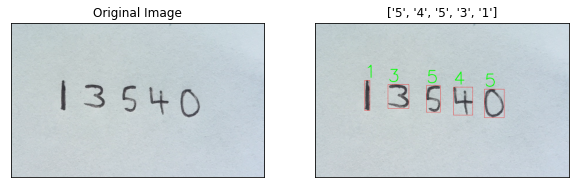

In [49]:
original = cv2.imread('./drive/MyDrive/DigitRecognition_Dataset/Test/text.jpg')
resultImage, resultDigit, image_countours, image_numbers = recognize_digit(cv2.imread('./drive/MyDrive/DigitRecognition_Dataset/Test/text.jpg'))
plt.figure(figsize = (10, 8))
plt.subplot(121)
plt.imshow(original, cmap = 'gray')
plt.title("Original Image")
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(resultImage, "gray")
plt.title(resultDigit)
plt.xticks([]), plt.yticks([])
plt.show()

Streamlit App

In [40]:
%%writefile app.py
import numpy as np
import streamlit as st
from streamlit_drawable_canvas import st_canvas
import cv2
import joblib

st.title("Drawable Digit Recognition using SVM")
st.markdown("> This app demonstrates Digit Recognition using SVM. The app allows users draw digits on to a canvas and an image with prediction digits will be shown as the result.")
st.markdown(">Disclaimer : The performance of our SVM Model on Drawable Digit Recognition showed a realistic results, with accuracy of 76.41%")
st.header("🎲 How to Use the Application")
st.markdown(
    """
    * Draw Digits freely as you want! 
    * You can Undo, Redo or Delete your drawing with button in the bottom left of the canvas 
    * Please Don't forget to Press ⬇️ Send Button in the bottom left of the canvas!
    * Press Predict Button if you're done with your drawing and the result will be shown bellow
    """
    )
st.write(" ")
st.write(" ")
st.write(" ")

st.markdown("Draw Digits [0-9]")
# Create a canvas component
canvas_result = st_canvas(
    fill_color="rgba(255, 165, 0, 0.3)",  # Fixed fill color with some opacity
    stroke_width=9,
    stroke_color="black",
    background_color="#eee",
    background_image=None,
    update_streamlit=False,
    height=270,
    width=700,
    drawing_mode="freedraw",
    point_display_radius= 0,
    display_toolbar=True,
    key="full_app",
)

predict = st.button("Predict")

model_svm_new = joblib.load("./drive/MyDrive/Colab Notebooks/DigitRecognition_SVM_Model.pt")

def drawSquare(image):
    '''
    Draws a square around the found digits
    '''		
    b = [0,0,0]
    height, width = image.shape[0], image.shape[1]
    if(height == width): ## if square
      square = image
      return square
    else:
      d_size = cv2.resize(image, (2*width, 2*height), interpolation=cv2.INTER_CUBIC)
      height, width = height * 2, width * 2
      if (height > width):
        padding = (height - width)/2; padding = int(padding)
        d_size_square = cv2.copyMakeBorder(d_size, 0, 0, padding, padding, cv2.BORDER_CONSTANT, None,value=b)
      else:
        padding = (width - height)/2; padding = int(padding)
        d_size_square = cv2.copyMakeBorder(d_size, padding, padding, 0, 0, cv2.BORDER_CONSTANT, None,value=b)

    return d_size_square

def resize(image, dim):
    '''
    Returns orignal image resized to shape 'dim'
    '''	
    b = [0,0,0]	 			
    dim = dim - 4
    squared = image
    r = (float(dim) / squared.shape[1])
    d = (dim, int(squared.shape[0] * r))
    resized = cv2.resize(image, d, interpolation = cv2.INTER_AREA)
    height, width = resized.shape[0], resized.shape[1];
    if (height > width):
      resized = cv2.copyMakeBorder(resized, 0,0,0,1, cv2.BORDER_CONSTANT, value=b)
    if (height < width):
      resized = cv2.copyMakeBorder(resized, 1,0,0,0, cv2.BORDER_CONSTANT, value=b)

    resized = cv2.copyMakeBorder(resized, 2,2,2,2,cv2.BORDER_CONSTANT, value=b)
    height, width = resized.shape[0], resized.shape[1]	
    
    return resized	

def recognize_digit(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 30, 150)

    contours, _ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in contours]

    # Found number in the image
    display = []

    for contour in contours:
      (x, y, w, h) = cv2.boundingRect(contour)
        
      if w>= 5 and h>=20:
        area = blur[y:y+h, x:x+w]
        ret, area = cv2.threshold(area, 127, 255, cv2.THRESH_BINARY_INV)
            
        new_square = drawSquare(area)
        number = resize(new_square, 20)
        result = number.reshape((1, 400)); 
        result = result.astype(np.float32);
        res = model_svm_new.predict(result)
        n = str(int(float(res)))
        display.append(n)


        # draw rectangle around individual digit
        cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(image, n, (x,y-8), cv2.FONT_ITALIC, 0.7, (0,255,0), 2)

    return image, display

# Do something interesting with the image data and paths
if canvas_result.image_data is not None and predict:
    resImg, resDigit = recognize_digit(canvas_result.image_data)
    st.markdown("Prediction Result")
    st.image(resImg)
    st.text("Digit Prediction : {}".format(resDigit))

Overwriting app.py


Local Tunnel

In [41]:
!streamlit run app.py & npx localtunnel --port 8501

2023-01-10 18:28:45.248 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


npx: installed 22 in 2.376s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.86.247.26:8501

your url is: https://crazy-terms-sneeze-34-86-247-26.loca.lt
  Stopping...
^C


Ngrok

In [30]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=0d43babcddde4206085a1ef8b9736c573985eb6fc4fda696befe1f7fa9419461
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [52]:
!streamlit run app.py &>/dev/null&

In [53]:
from pyngrok import ngrok
!ngrok authtoken 2K5VMsLbfPowtf2cr81cJBK9NSq_5woqSrwvdkEpaCqsU9LdJ

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [54]:
public_url = ngrok.connect(port='8501')
public_url

<NgrokTunnel: "http://1aa8-34-82-241-231.ngrok.io" -> "http://localhost:80">

In [56]:
# Kill Ngrok After Use
ngrok.kill()

Streamlit Create Dataset

In [243]:
%%writefile app.py
import numpy as np
import streamlit as st
from streamlit_drawable_canvas import st_canvas
import cv2
import uuid
from io import BytesIO, BufferedReader


st.title("Drawable Canvas for Digit Recognition Dataset")
st.markdown(">The app lets users draw digit on to a canvas and input label of the drawed digit. Then it will show the inputted data and user can download drawed digit image for Digit Recognition Dataset")
st.header("🎲 How to Use the Application")
st.markdown(
     """
    * Draw Digit as your desire 
    * You can Undo, Redo or Delete your drawing with button in the bottom left of the canvas 
    * Please Don't forget to Press ⬇️ Send Button in the bottom left of the canvas!
    * Input the Drawed Digit label in the Label Section!
    * Press Input Button if you're done with your drawing and the inputted data will be shown bellow
    * Now download Button will be appear!  
    * Press download Button and the drawed digit image will be downloaded for your dataset!
    """
    )
st.write(" ")
st.write(" ")
st.write(" ")

st.markdown("Draw Digit [0-9]")
# Create a canvas component
canvas_result = st_canvas(
    fill_color="rgba(255, 165, 0, 0.3)",  # Fixed fill color with some opacity
    stroke_width=9,
    stroke_color="white",
    background_color="#000000",
    background_image=None,
    update_streamlit=False,
    height=250,
    width=700,
    drawing_mode="freedraw",
    point_display_radius= 0,
    display_toolbar=True,
    key="full_app",
)

label = st.text_input('Label', '')

input = st.button("Input")

# Do something interesting with the image data and paths
if canvas_result.image_data is not None and input:
    st.markdown("Inputted Data")
    st.image(canvas_result.image_data)
    st.text("Label : {}".format(label))

    random = uuid.uuid4().hex
    ret, img_enco = cv2.imencode(".png", canvas_result.image_data) 
    srt_enco = img_enco.tostring() 
    img_BytesIO = BytesIO(srt_enco)
    img_BufferedReader = BufferedReader(img_BytesIO)

    btn = st.download_button(
            label="Download the Image",
            data=img_BufferedReader,
            file_name= label + "-" + random +".png",
            mime="image/png"
          )

Overwriting app.py
